In [1]:
import pandas as pd
import os
from tqdm import tqdm
from sportypy.surfaces import MiLBField
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotting import plot_animation

In [3]:
base = '/Users/eddie/SMT-Data-Challenge/Combined/'

In [4]:
game_events = pd.read_parquet(base + 'game_events.parquet')
game_info = pd.read_parquet(base + 'game_info.parquet')
team_info = pd.read_parquet(base + 'team_info.parquet')

In [5]:
game_events.sort_values(by=['game_str', 'timestamp', 'event_code'], inplace = True)

In [6]:
df = []

for subdir, dirs, files in os.walk(base + 'ball_pos/'):
    for file in files:
        sub_df = pd.read_parquet(base + 'ball_pos/' + file)
        df.append(sub_df)

ball_pos = pd.concat(df, ignore_index=True)

In [7]:
df = []  

for subdir, dirs, files in os.walk(base + 'player_pos/'):
    for file in tqdm(files, desc='Processing File'):
        sub_df = pd.read_parquet(base + 'player_pos/' + file, engine='fastparquet')
        df.append(sub_df)

player_pos = pd.concat(df, ignore_index=True)

Processing File: 100%|████████████████████████| 338/338 [00:05<00:00, 61.99it/s]
Processing File: 0it [00:00, ?it/s]


# Data Notes:

* Game ##.5 indicates a double header and that is the second game.
* All home teams are within the same farm system.
* Home 4A is highest and 1A is the lowest.
* 1883 season is only half a season and 1884 is a full season.
* Play ids **reset** every game

*player position codes*:
```
{
    1: pitcher
    2: catcher
    3: 1st Baseman
    4: 2nd Baseman
    5: Third basebam
    6: Shortstop
    7: Left Field
    8: Center Field
    9: Right Field
    10: Batter
    11: Runner on first
    12: Runner on second
    13: Runner on third
    255: Ball event with no player (past ball)
}
```
*event codes*:
```
{
    1: Pitch thrown
    2: Ball acquired
    3: Throw for ball in play
    4: Ball hit into play
    5: End of play
    6: Pickoff Throw
    7: Ball acquired: Unkown field position
    8: Throw for ball in play: Unknown field position
    9: Ball deflection
    10: Ball deflection off wall
    11: Home run
    16: Ball bounce
}
```

Question at hand: This year’s dataset will consist of multiple teams within a single farm system. We want you to consider a situation that compares
players, teams, and/or game play at two or more levels.

In [8]:
# Decode the Game Events

PLAYER_POSITION = {
    1: 'P',
    2: 'C',
    3: '1B',
    4: '2B',
    5: '3B',
    6: 'SS',
    7: 'LF',
    8: 'CF',
    9: 'RF',
    10: 'BA', # The batter
    11: 'R1B', # Runner on 1B
    12: 'R2B', # Runner on 2B
    13: 'R3B', # Runner on 3B
    255: 'NA' # Ball event with no player
}

EVENT_CODE = {
    1: 'Pitch',
    2: 'Fielded', # fielded ball
    3: 'Throw', # ball thrown
    4: 'In Play',
    5: 'End of Play',
    6: 'Pickoff',
    7: 'Fielded (Unknown)',
    8: 'Throw (Unknown)',
    9: 'Ball Deflection',
    10: 'Off Wall',
    11: 'HR',
    16: 'Ball Bounce' # Can bounce multiple times
}


game_events['player_position'] = game_events['player_position'].map(PLAYER_POSITION)
game_events['event_code'] = game_events['event_code'].map(EVENT_CODE)


In [9]:
outfield_positions = ['CF', 'RF', 'LF']

game_events['is_flyout'] = np.where(
    (game_events['player_position'].isin(outfield_positions)) & 
    (game_events['event_code'].isin(['Fielded', 'Ball Deflection'])) & # Want ball deflections as they could be fielding errors but an attempt by the outfielder to get to the ball.
    (game_events['event_code'].shift(1) == 'In Play'), 1, 0
)

In [10]:
game_events[game_events['is_flyout'] == 1]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,is_flyout
55093,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,1
55100,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,1
55281,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,1
55291,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,1
55350,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,1
...,...,...,...,...,...,...,...,...
212043,1884_143_Vis4BE_Home4A,253,62.0,252,8606500,LF,Fielded,1
212102,1884_143_Vis4BE_Home4A,268,67.0,267,9346300,RF,Fielded,1
212127,1884_143_Vis4BE_Home4A,274,69.0,273,9621300,CF,Fielded,1
212154,1884_143_Vis4BE_Home4A,281,71.0,280,9770950,RF,Fielded,1


In [11]:
batter = player_pos[player_pos['player_position'] == 10].copy()

first_field_x = batter.groupby(['game_str', 'play_id'])['field_x'].transform('first')
batter['handedness'] = np.where(first_field_x > 0, 'L', 'R')
handedness_df = batter.groupby(['game_str', 'play_id'])['handedness'].first().reset_index()

player_pos = player_pos.merge(handedness_df, on=['game_str', 'play_id'], how='left')



In [12]:
hit = game_events[game_events['event_code'] == 'In Play'].rename(columns = {'timestamp' : 'start_time'})
# Start time = when the ball is hit into play

fielded = game_events[game_events['is_flyout'] == 1]

In [13]:
filter_v = pd.merge(fielded, hit, on = ['game_str', 'play_id'], how = 'inner', suffixes = ('', '_hit')).rename(columns={'timestamp' : 'end_time'})



In [14]:
filter_v = filter_v.iloc[:,:-3]
filter_v.drop(['at_bat_hit', 'play_per_game_hit', 'is_flyout'], axis = 1, inplace=True)

player_ids = game_info[['game_str', 'play_per_game', 'inning', 'at_bat', 'top_bottom', 'left_field', 'center_field', 'right_field']]

filter_v = pd.merge(filter_v, player_ids, on = ['game_str', 'at_bat', 'play_per_game'], how = 'inner')

filter_v[['left_field', 'center_field', 'right_field']] = filter_v.groupby(['game_str', 'top_bottom'])[['left_field', 'center_field', 'right_field']].ffill()

# Filling in player ids
filter_v['player_id'] = np.where(
    filter_v['player_position'] == 'LF', filter_v['left_field'],
    np.where(
        filter_v['player_position'] == 'CF', filter_v['center_field'],
        filter_v['right_field']
    )
)

filter_v.drop(columns=['top_bottom', 'left_field', 'center_field', 'right_field'], inplace=True)

In [15]:
outfielders = player_pos[player_pos['player_position'].isin([7, 8, 9])].copy()
outfielders['player_position'] = outfielders['player_position'].map(PLAYER_POSITION)

In [16]:
player_pos_out = pd.merge(filter_v, outfielders, left_on=['game_str', 'play_id', 'start_time', 'player_position'], right_on = ['game_str', 'play_id', 'timestamp', 'player_position'], how='left').drop('timestamp', axis = 1)



In [17]:
ball_pos_out = pd.merge(filter_v, ball_pos, left_on=['game_str', 'play_id', 'end_time'], right_on = ['game_str', 'play_id', 'timestamp'], how='left').drop('timestamp', axis = 1)
ball_pos_out = ball_pos_out[['game_str', 'play_id', 'at_bat', 'ball_position_x', 'ball_position_y', 'ball_position_z']]


# Removed about 36 rows that were bad data
final = pd.merge(player_pos_out, ball_pos_out, on = ['game_str', 'play_id', 'at_bat'], how = 'left').dropna(subset = ['field_x', 'ball_position_x'])



In [18]:
# Find maximum player location
max_out_location = outfielders.loc[outfielders.groupby(['game_str', 'play_id', 'player_position'])['timestamp'].idxmax(), 
                ['game_str', 'play_id', 'player_position', 'field_x', 'field_y']].rename(columns={
    'field_x': 'field_end_x', 'field_y': 'field_end_y'})



In [19]:
def derive_hitting_metrics(df):
    dx = df.groupby(['game_str', 'play_id'])['ball_position_x'].diff() 
    dy = df.groupby(['game_str', 'play_id'])['ball_position_y'].diff()
    dz = df.groupby(['game_str', 'play_id'])['ball_position_z'].diff()
    
    # Timestamp diff
    dt = df.groupby(['game_str', 'play_id'])['timestamp'].diff()
    
    # velocity vectors
    vx = dx / dt
    vy = dy / dt
    vz = dz / dt
    
    # Exit velocity = magnitude of the displacement vectors
    df['exit_velocity'] = (np.sqrt(vx**2 + vy**2 + vz**2)) * 3600000 / 5280 # miles per hour
    # Inverse tan of the perpendicular (z coordinate) / base (distance between x and y vectors)
    # (-) z coordinates so take the absolute value of them.
    df['launch_angle'] = np.degrees(np.arctan2(abs(vz), np.sqrt(vx**2 + vy**2)))
    
    return df
    
    

In [20]:
# Find the timestamps where the ball makes contact then derive the launch angle and exit velo
# First I need to find the timestamp of the hit then derive the difference of the next two timestamps.
# In filter_v start time = what I want. Just need the next 2

contact_df = ball_pos.merge(filter_v, left_on = ['game_str', 'play_id'], right_on = ['game_str', 'play_id'], how = 'inner')
contact_df = contact_df[(contact_df['timestamp'] >= contact_df['start_time']) &
                       (contact_df['end_time'] >= contact_df['timestamp'])]
contact_df = derive_hitting_metrics(contact_df)

# 2nd to 5th observation to eliminate possible error from initial hit.
contact_df = contact_df.groupby(['game_str', 'play_id'])[['exit_velocity', 'launch_angle']].apply(lambda x: x.iloc[1:5].mean()).reset_index()



In [22]:
final = pd.merge(final, contact_df, on = ['game_str', 'play_id'], how = 'left')
final = pd.merge(final, max_out_location, on = ['game_str', 'play_id', 'player_position'], how = 'left')

In [23]:
# This filters plays where an outfielder fields the ball, a total of 4,064 observations. 

final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,start_time,inning,player_id,field_x,field_y,handedness,ball_position_x,ball_position_y,ball_position_z,exit_velocity,launch_angle,field_end_x,field_end_y
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,67773,1,594.0,-5.6358,308.5794,R,-16.98135,329.4720,4.787370,81.734102,36.822336,-18.0411,328.0791
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,114723,1,492.0,-125.0325,241.4478,L,-133.04100,182.3649,4.718250,75.201857,47.196069,-131.9796,178.2810
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,1621073,2,NaN,-1.0332,311.2104,L,29.13606,260.8020,2.199318,67.738023,23.938940,30.5283,244.6044
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,1700073,2,NaN,-131.7357,266.6529,R,-89.36070,302.4690,3.871440,96.605867,21.745768,-86.8119,308.9538
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,2062623,3,537.0,126.2733,231.2652,R,100.18980,313.6980,6.418260,100.555112,25.267411,96.4707,330.6606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,1884_142_Vis4BE_Home4A,206,55.0,207,7422459,RF,Fielded,7416159,7,502.0,135.5568,243.9789,R,146.94600,175.7655,6.102000,95.203626,54.793095,150.7056,177.0066
4060,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,8206859,7,6466.0,131.9016,259.6098,R,125.81310,314.5740,5.314890,100.107820,31.172241,132.9711,323.6319
4061,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,8471509,8,861.0,25.4760,304.4340,R,75.99360,300.5610,5.442150,101.744036,37.217006,79.8729,300.5508
4062,1884_142_Vis4BE_Home4A,257,71.0,259,9662709,LF,Fielded,9659159,8,2188.0,-140.7099,228.7614,L,-179.86470,219.5319,6.831900,68.887954,23.794789,-189.3228,222.6675


In [45]:
def plot_heatmap(df):
    field = MiLBField()

    plt.figure(figsize=(12, 10))

    field.draw()

    positions = ['LF', 'CF', 'RF']

    for position in positions:
        position_data = df[df['player_position'] == position]
        sns.kdeplot(
            x=position_data['ball_position_x'],
            y=position_data['ball_position_y'],
            cmap='magma',
            alpha=0.6,
            fill = True,
            levels = 8,
            ax=plt.gca()
        )

        plt.text(position_data.field_x.mean(), position_data.field_y.mean(), 
                 position, fontsize=12, ha='center', color='black', fontweight = 'bold')

    plt.title('Heatmap of Flyball Attempts by Outfielders', c = 'w')

    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

<Figure size 1200x1000 with 0 Axes>

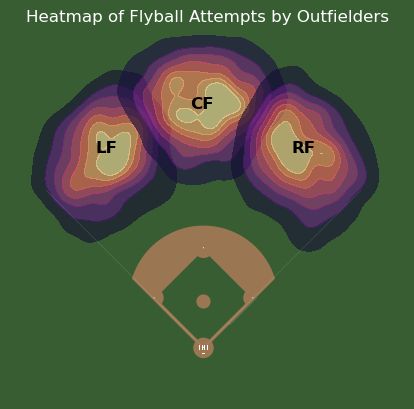

In [46]:
plot_heatmap(final)

In [244]:
# 94,499 events

(4064 / 94499) * 100
# About 4% of our plays are flyouts or dropped fly balls.

# CF	1595
# LF	1264
# RF	1205 Play totals <–

4.300574609255124

# Steps to Take

Identify how to make a range map. Essentially, it will be for **any** fly ball so I will need to find where a player is in their starting position then where they end up on the field. You draw a line with opacity to it and it should output something like this:
[Outfield](https://grantland.com/the-triangle/2014-mlb-playoffs-exploiting-kansas-city-royals-ultimate-outfield-jarrod-dyson-alex-gordon-lorenzo-cain/)
This is going to be used for route efficiency. 


Here's what the model will be initially:
* Input features like hang time, angle to the ball, etc.
* Outputs the expected time for a player to reach the ball. 
* Compare it throughout the different leagues to see what players are getting to the ball.
* Once I have it, I could make a hexbin plot of where players are strong suited to where they may get to the ball from the outfield. 
* *Maybe* normalize it?


In [29]:
actual_routes = pd.merge(final, outfielders, on =['game_str', 'play_id', 'player_position'], how = 'left', suffixes = ('', '_int'))

distances = []
for (game_str, play_id), play in tqdm(actual_routes.groupby(['game_str', 'play_id']), desc = 'Extracting distance'):
    play['x_diff'] = play['field_x_int'].diff().fillna(0)
    play['y_diff'] = play['field_y_int'].diff().fillna(0)
    
    play['timestamp'] = play['timestamp'] / 1000
    
    play['time_diff'] = play['timestamp'].diff().fillna(0)
    
    play['stepwise_diff'] = np.sqrt(play['x_diff']**2 + play['y_diff'] ** 2)
    
    play['speed'] = play['stepwise_diff'] / play['time_diff']
    
    distance = np.sum(play['stepwise_diff'])
    
    max_speed = play['speed'].max()
    mean_speed =  play['speed'].mean()
    
    distances.append({'game_str': game_str, 'play_id': play_id,
                      'actual_distance': distance, 'max_speed': max_speed, 'mean_speed': mean_speed})



Extracting distance: 100%|████████████████| 4061/4061 [00:02<00:00, 1449.04it/s]


In [30]:
actual_routes = pd.DataFrame(distances)
final = pd.merge(final, actual_routes, on = ['game_str', 'play_id'], how = 'left')

In [31]:
final['straight_line'] = np.sqrt((final['field_end_x'] - final['field_x']) ** 2 + 
                                (final['field_end_y'] - final['field_y']) ** 2)


final['route_efficiency'] = final['straight_line'] / final['actual_distance']

final['max_player_speed'] = final.groupby('player_id')['mean_speed'].transform('max')

final['max_player_speed'].fillna(12.877761, inplace = True) # gonna fill in with the median speed

final['actual_time'] = (final['end_time'] - final['start_time']) / 1000

In [33]:
final.isna().sum()

game_str              0
play_id               0
at_bat              161
play_per_game         0
end_time              0
player_position       0
event_code            0
start_time            0
inning                0
player_id           504
field_x               0
field_y               0
handedness            0
ball_position_x       0
ball_position_y       0
ball_position_z       0
exit_velocity         0
launch_angle          0
field_end_x           0
field_end_y           0
actual_distance       0
max_speed             0
mean_speed            0
straight_line         0
route_efficiency      0
max_player_speed      0
actual_time           0
dtype: int64

In [52]:
final.query('launch_angle < 10')['exit_velocity']

24       47.731857
113      84.888331
427     116.540670
2019     51.544080
2238     56.598664
2440    116.550629
3211    116.356517
3609    111.109544
3863     79.827758
4063     75.198100
Name: exit_velocity, dtype: float64

<Axes: >

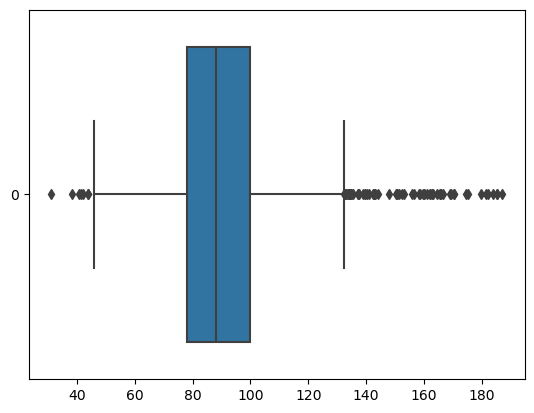

In [51]:
sns.boxplot(final['exit_velocity'], orient='h')

<Axes: >

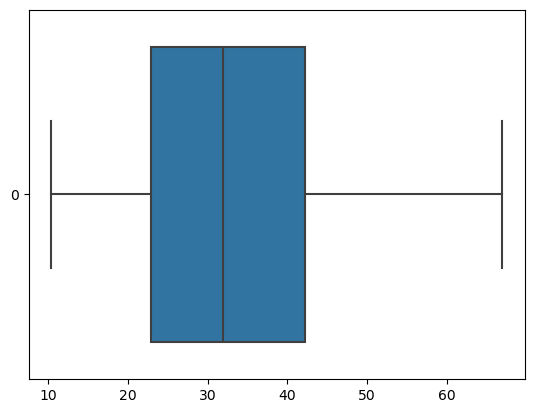

In [53]:
sns.boxplot(final.query('launch_angle > 10')['launch_angle'], orient='h')

In [103]:
# Gonna remove bad data for launch angle
# Reason being this:

# As a guideline, here are the Launch Angles for different types of contact:

# Ground ball: Less than 10 degrees
# Line drive: 10-25 degrees
# Fly ball: 25-50 degrees
# Pop up: Greater than 50 degrees


# Grabbed the 2nd to 5th timestamp window 
# There are 10 launch angle positions that are not correct. Bad data?

final = final.query('launch_angle > 10')

In [107]:
final['league'] = final['game_str'].apply(lambda x: x.split('_')[-1])
final['handedness_encode'] = cool['handedness'].map({'L' : 0, 'R' : 1}) # Batter handedness

/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_47522/561062963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['league'] = final['game_str'].apply(lambda x: x.split('_')[-1])
/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_47522/561062963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['handedness_encode'] = cool['handedness'].map({'L' : 0, 'R' : 1}) # Batter handedness


In [106]:
# This is good that there is a balance amongst the league numbers so it won't overfit to a particular league... hopefully.

final.league.value_counts()

league
Home4A    1069
Home1A    1058
Home3A    1009
Home2A     918
Name: count, dtype: int64

In [113]:
final.player_position.value_counts()

player_position
CF    1593
LF    1258
RF    1203
Name: count, dtype: int64

In [115]:
final.player_id.value_counts().head(10)

player_id
651.0    128
495.0    121
963.0    115
475.0    114
492.0    104
892.0     96
460.0     85
537.0     83
435.0     81
975.0     78
Name: count, dtype: int64

In [116]:
final.to_csv('./Clean/flyball_data.csv', index = False)

In [2]:
help(plot_animation)

Help on function plot_animation in module plotting:

plot_animation(player_position_df: pandas.core.frame.DataFrame, ball_position_df: pandas.core.frame.DataFrame, play_id: int = 1, save_gif: bool = False) -> IPython.core.display.HTML
    A function that plots field animations for a particular instance of a game.
    Example usage:
    
    ```
    player_pos = pd.read_parquet('./Combined/player_pos/1884_110_Vis2AR_Home2A.parquet')
    ball_pos = pd.read_parquet('./Combined/ball_pos/1884_110_Vis2AR_Home2A.parquet')
    
    plot_animation(player_pos, ball_pos, play_id = 30, save_gif = True)
    ```
    
    Params:
        player_position_df: A Data Frame for the player position coordinates on a field.
        ball_position_df: A Data Frame for the ball position coordiantes on a field.
        play_id: A integer field that denotes the play id you want to visualize. Defaults to 1.
        save_gif: A boolean that when set to true saves the animation to a gif. 
                  Defaults

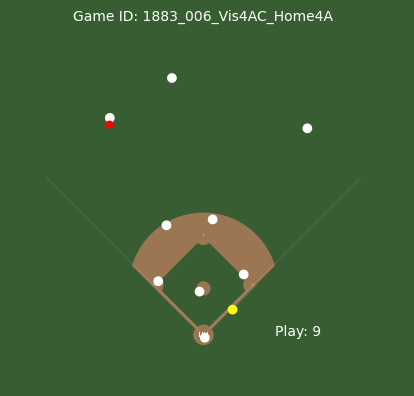

In [305]:
pp = pd.read_parquet('./Combined/player_pos/1883_006_Vis4AC_Home4A.parquet')
bp = pd.read_parquet('./Combined/ball_pos/1883_006_Vis4AC_Home4A.parquet')

plot_animation(pp, bp, play_id = 9)

In [158]:
unique_teams = team_info.groupby('player_id')['home_team'].nunique().sort_values(ascending = False).reset_index()


positions = game_info.iloc[:, 7:16]

players = {}
for position in positions.columns:
    players[position] = set(positions[position].dropna())
    
    
for position, ids in players.items():
    for id_ in ids:
        team_indices = unique_teams.index[unique_teams['player_id'] == id_].tolist()
        unique_teams.loc[team_indices, 'position'] = position
        
unique_teams[unique_teams['home_team'] > 1]['position'].value_counts()

position
pitcher         42
right_field     10
shortstop        7
catcher          6
center_field     5
left_field       4
third_base       4
first_base       3
second_base      2
Name: count, dtype: int64

In [165]:
unique_teams['position'].value_counts()

position
pitcher         110
right_field      27
catcher          14
shortstop        13
first_base       10
center_field     10
left_field        8
third_base        8
second_base       2
nan               1
Name: count, dtype: int64